In [37]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import FinanceDataReader as fdr
import os 
import pickle
import xgboost
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [3]:
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS = None  # Ignore DecompressionBombError

In [29]:
def Merge_DJI(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
    dji_df=DJI_df.drop(['Open','High','Low','Change'],axis=1)
    dji_df.rename({'Close':'dji_c','Volume':'dji_v'},axis=1,inplace=True)
    input_df=pd.merge(input_df,dji_df,how='outer',on='Date')
    
    return input_df

In [31]:
def Merge_ECR(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    exr=fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
    exr=exr.drop(['Open','High','Low','Change'],axis=1)
    exr.rename({'Close':'exc_c'},axis=1,inplace=True)
    input_df=pd.merge(input_df,exr,how='outer',on='Date')
    input_df=input_df.fillna(method='ffill')
    input_df=input_df.fillna(method='bfill')
    
    return input_df

In [32]:
def Merge_hr(input_df):
    HR_3y_df=pd.read_csv("hash-rate_3y.csv")
    HR_all_df=pd.read_csv("hash-rate_alltime.csv")
    HR_df=HR_all_df.iloc[715:1255]
    HR_df=pd.concat([HR_df,HR_3y_df])
    a=pd.date_range(start=str(input_df['Date'].iloc[0]),end=str(input_df['Date'].iloc[-1]))
    HR_ori_df=pd.DataFrame(a)
    HR_ori_df.rename({0:'Timestamp'},axis=1,inplace=True)
    
    for i in range(len(HR_ori_df['Timestamp'])):
        HR_ori_df['Timestamp'].iloc[i]=str(HR_ori_df['Timestamp'].iloc[i])
        
    HR_ori_df=pd.merge(HR_ori_df,HR_df,how='outer',on='Timestamp')
    HR_ori_df=HR_ori_df[:len(a)+1]
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df=HR_ori_df.fillna(method='ffill')
    HR_ori_df=HR_ori_df.fillna(method='bfill')
    HR_ori_df.rename({'Timestamp':'Date'},axis=1,inplace=True)
    
    for i in range(len(input_df['Date'])):
        input_df['Date'].iloc[i]=str(input_df['Date'].iloc[i])
        
    input_df=pd.merge(input_df,HR_ori_df,how='outer',on='Date')
    
    return input_df

In [33]:
def preprocessing(input_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        input_df[f'{i}_close']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'{i}_close']=input_df['c'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        input_df[f'p_lag_{lag}'] = -1
        input_df[f'q_lag_{lag}'] = -1 
        input_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(input_df)):
            input_df.loc[index, f'p_lag_{lag}'] = input_df['c'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            input_df.loc[index, f'q_lag_{lag}'] = input_df['v'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            input_df.loc[index, f'pq_lag_{lag}'] = (input_df['c'][index-lag]*input_df['v'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가

In [34]:
def OBV_preprocessing(input_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(input_df)):
        if input_df['c'].iloc[i] > input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]+input_df['v'].iloc[i])
        elif price_df['c'].iloc[i]<input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]-input_df['v'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    input_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    input_df['obv_ema']=input_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    input_df['signal_obv']=input_df['obv']-input_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        input_df[f'obv_lag{i}']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'obv_lag{i}']=input_df['signal_obv'].rolling(window=i).mean()

In [35]:
def gen_train_test2(input_df):
    input_df['target']=0
    for i in range(len(input_df)-1):
        input_df['target'].iloc[i]=input_df['c'].iloc[i+1]

In [28]:
with open("btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df=df.reset_index()
    df.rename({'ot':'Date'},axis=1,inplace=True)
df

,Date,o,h,l,c,v
0,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
1,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
3,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
4,2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...,...
2609,2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2610,2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2611,2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03
2612,2022-01-23,35084.79,36574.47,34624.59,36293.62,2.533704e+03


In [138]:
test_df=df[:]
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_hr(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df
price_df=price_df.drop(['h','l'],axis=1)

In [139]:
final_price_df=price_df[31:2604]
len(final_price_df)

2573

In [140]:
final_price_df.set_index('Date',inplace=True,drop=True)

In [141]:
final_price_df

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-30 00:00:00,314.78,311.94,3.091942e+06,17983.07,47490000.0,1096.92,2.863719e+05,-1.419967e+07,-7.861093e+06,-6.338578e+06,...,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08,329.99,3.617197e+06,1.193639e+09,319.25
2014-12-31 00:00:00,311.94,319.25,1.925335e+06,17823.07,82840000.0,1093.90,2.863719e+05,-1.227434e+07,-8.123744e+06,-4.150592e+06,...,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08,316.31
2015-01-01 00:00:00,319.25,316.31,1.018388e+06,17823.07,82840000.0,1092.45,2.863719e+05,-1.329272e+07,-8.427756e+06,-4.864968e+06,...,322.14,1.826465e+06,5.883775e+08,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09,316.51
2015-01-02 00:00:00,316.31,316.51,1.093572e+06,17832.99,76270000.0,1106.92,3.232437e+05,-1.219915e+07,-8.647114e+06,-3.552039e+06,...,319.39,1.255322e+06,4.009373e+08,322.14,1.826465e+06,5.883775e+08,335.49,2.604314e+06,8.737214e+08,286.01
2015-01-03 00:00:00,316.51,286.01,6.078845e+06,17832.99,76270000.0,1106.92,3.232437e+05,-1.827800e+07,-9.201435e+06,-9.076563e+06,...,330.88,2.066944e+06,6.839105e+08,319.39,1.255322e+06,4.009373e+08,322.14,1.826465e+06,5.883775e+08,264.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,47350.22,7.020948e+02,3.324434e+07,47777.42,7.415206e+02,3.542794e+07,46214.37,1.798553e+03,8.311898e+07,42736.00
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,46439.89,1.140179e+03,5.294979e+07,47350.22,7.020948e+02,3.324434e+07,47777.42,7.415206e+02,3.542794e+07,43933.50
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,45820.00,1.832613e+03,8.397032e+07,46439.89,1.140179e+03,5.294979e+07,47350.22,7.020948e+02,3.324434e+07,42571.94


In [142]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]


def backtest_arima_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft-1], batch_df[ft-1:ft]
            X_train, y_train = train.drop('target',axis=1,inplace=False),train['target']
            X_test, y_test = test.drop('target',axis=1,inplace=False),test['target']
            xgb = XGBRegressor()
            xgb.fit(X_train, y_train)
            pred = xgb.predict(X_test)
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].o
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass

    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['c'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['c'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

2273it [09:27,  4.00it/s]


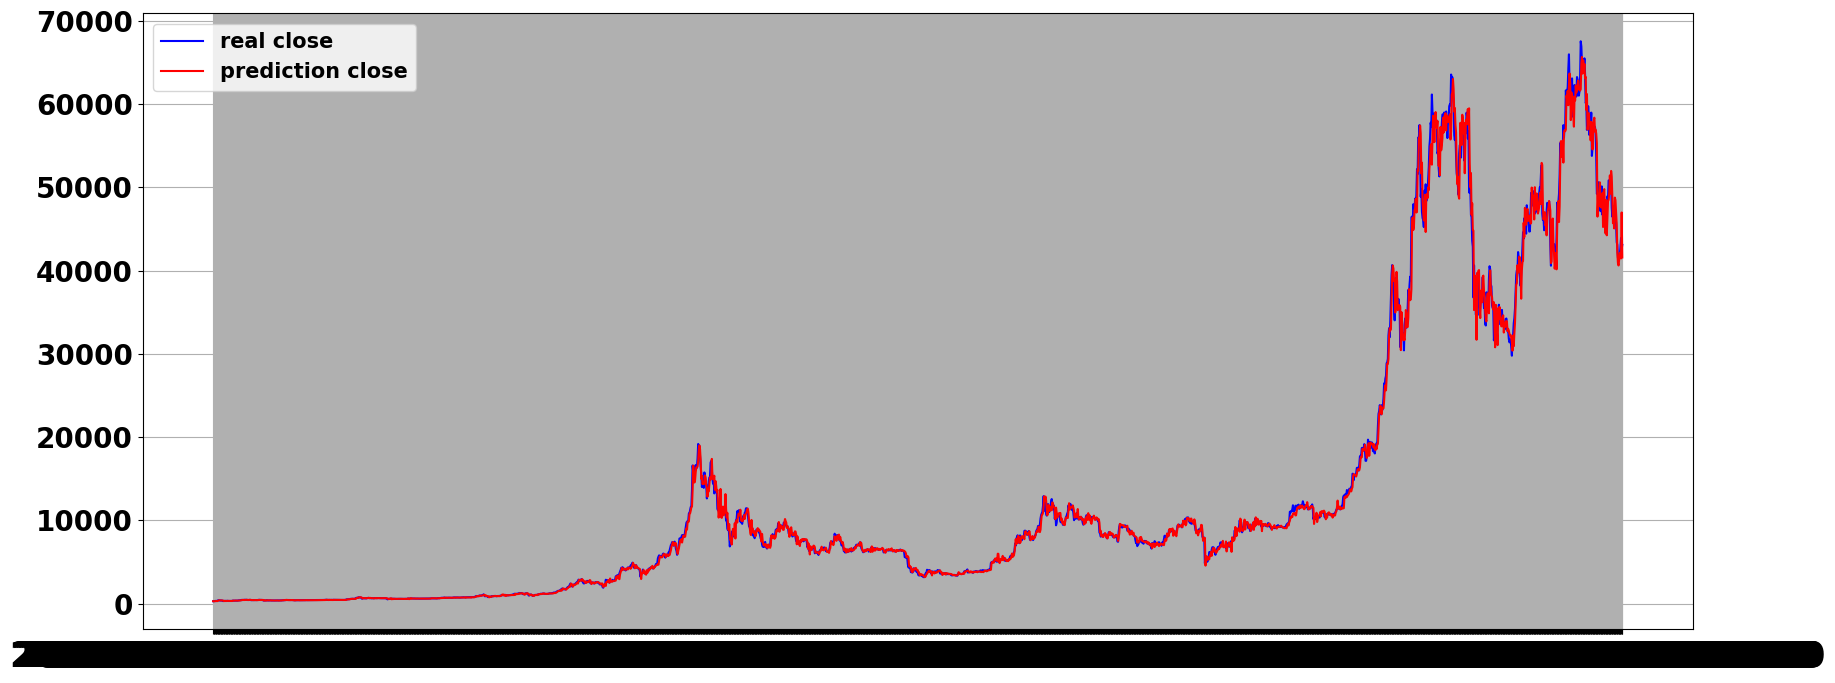

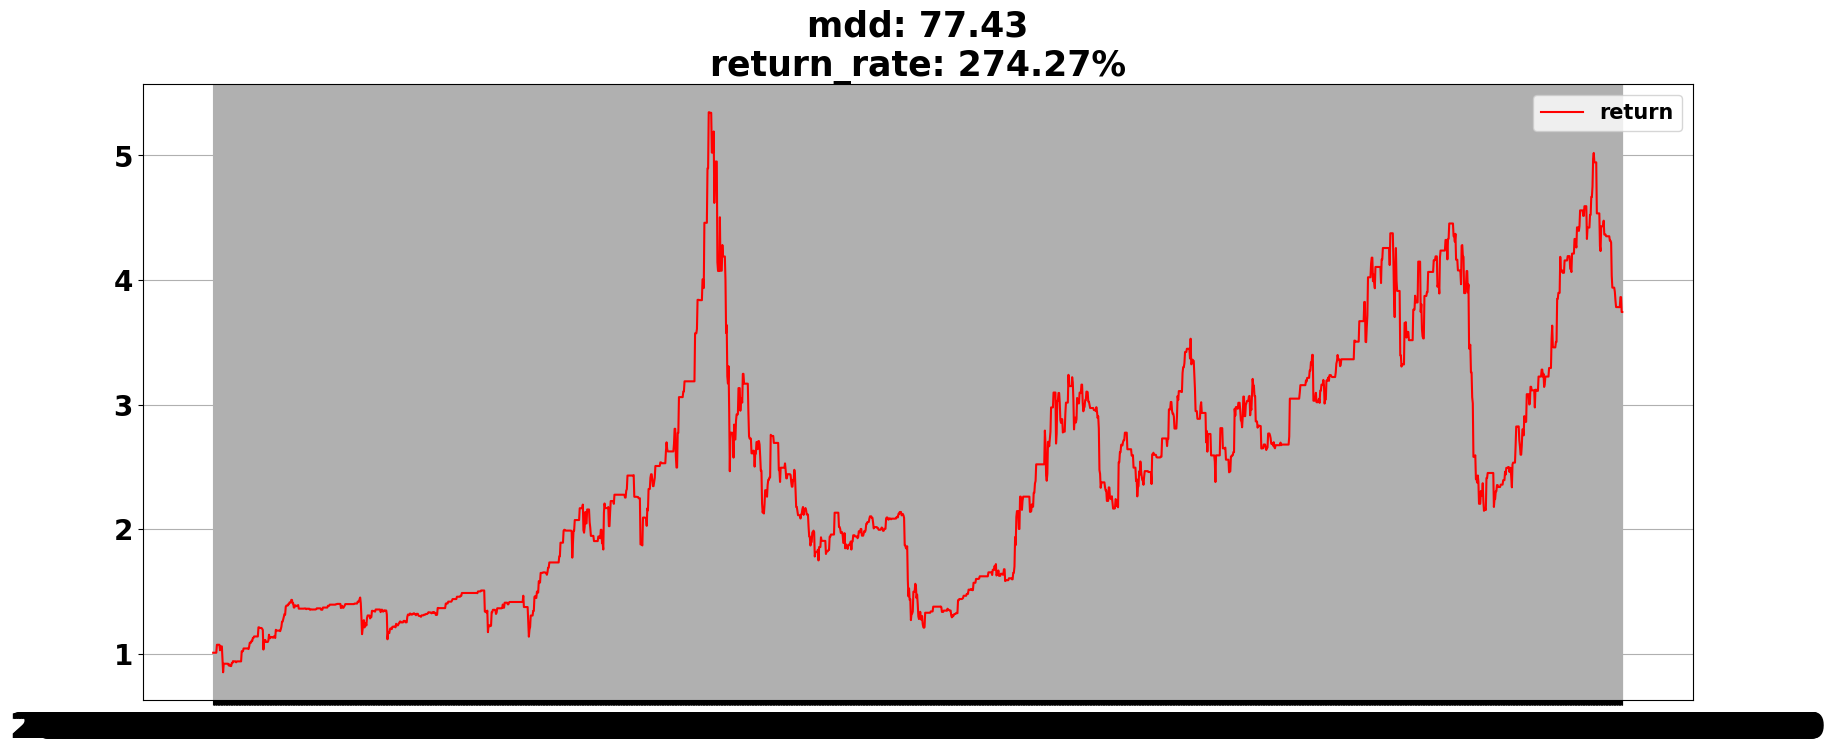

In [143]:
result_df = backtest_arima_1d(final_price_df,300, 1)

In [144]:
analysis_return(result_df)

{'trade_rate': ' 45.49%',
 'success_rate': ' 53.87%',
 'pnl_rate': ' 1.17',
 'mdd': ' 77.43%',
 'cr': ' 274.27%'}